# GPR with optimization from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error

# Set plotting style
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## The dataset

### Load and present data

In [5]:
df = pd.read_csv('../data/co2_clean.csv')
co2_mean = df['CO2'].mean()
co2_std = df['CO2'].std()
display(df.columns)
display(df)

Index(['Date', 'CO2'], dtype='object')

,Date,CO2
0,1958-03-01,315.70
1,1958-04-01,317.45
2,1958-05-01,317.51
3,1958-07-01,315.86
4,1958-08-01,314.93
...,...,...
756,2021-08-01,414.34
757,2021-09-01,412.90
758,2021-10-01,413.55
759,2021-11-01,414.82


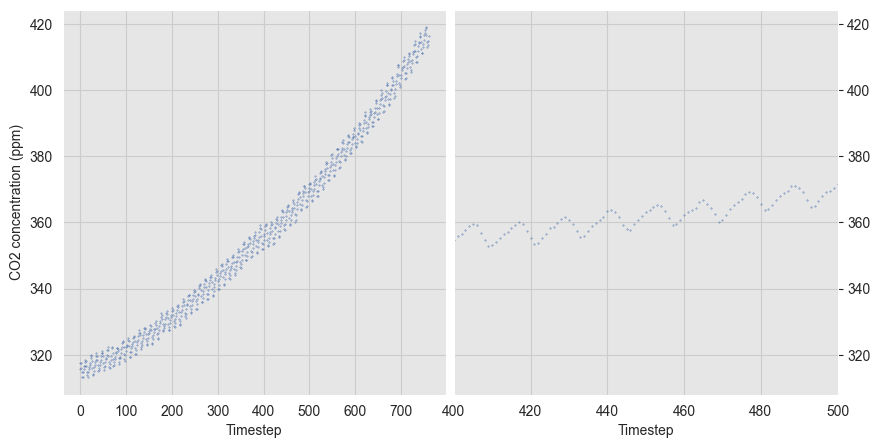

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(df.index, df["CO2"], s=0.1)
ax[0].set_ylabel("CO2 concentration (ppm)")
ax[1].scatter(df.index, df["CO2"], s=0.1)
ax[1].set_xlim((400, 500))
ax[1].yaxis.tick_right()
ax[0].set_xlabel("Timestep")
ax[1].set_xlabel("Timestep")

plt.subplots_adjust(wspace=0.02)
plt.show()

### Create training and testing sets

In [7]:
split_ratio = 0.8
n = len(df)
n_train = int(n * split_ratio)

# Convert data to numpy arrays
x = df.index.values.reshape(-1, 1)
y = df['CO2'].values.reshape(n, 1)

# Split data into training and test sets
x_train = x[:n_train]
x_test = x[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

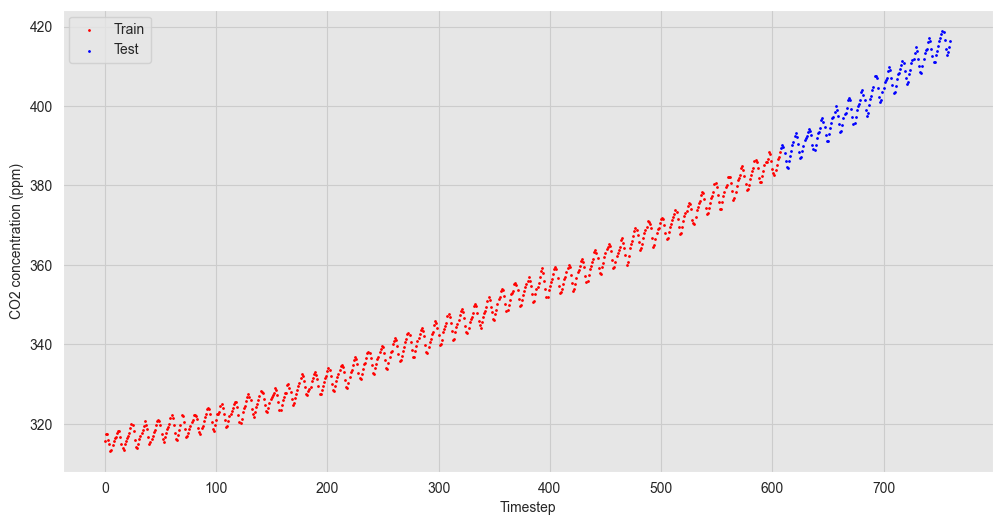

In [9]:
plt.scatter(x_train, y_train, c='r', s=1., label='Train')
plt.scatter(x_test, y_test, c='b', s=1., label='Test')
plt.xlabel('Timestep')
plt.ylabel('CO2 concentration (ppm)')
plt.legend()
plt.show()

## Model fitting

### Define the GP kernel function

In [134]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=100, constant_value_bounds=(1, 500)) * \
  RationalQuadratic(length_scale=500, length_scale_bounds=(1, 1e4), alpha= 50.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3

### Draw samples from the GP prior

In [135]:
# Define GaussianProcessRegressor object. 
gp3 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0,
)

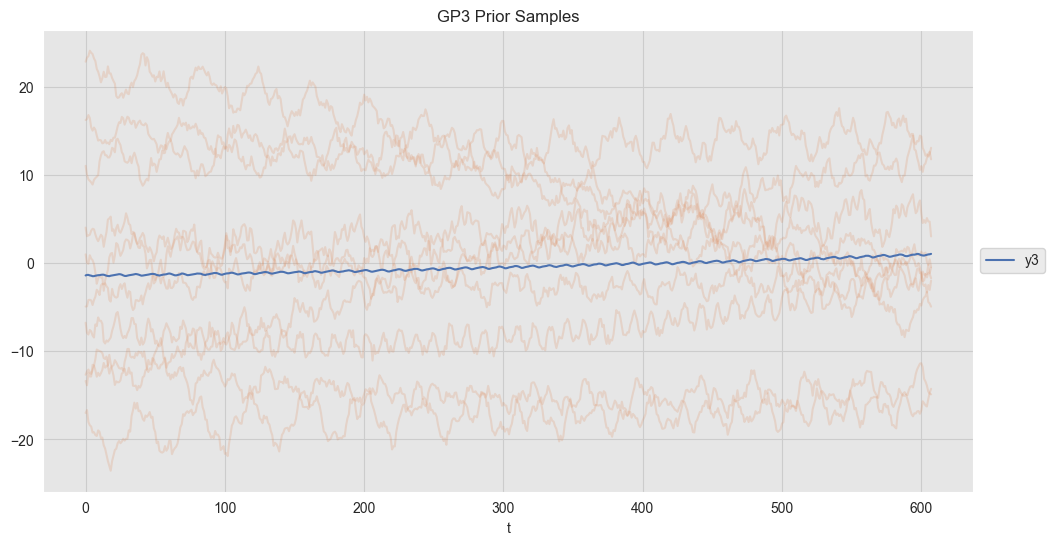

In [136]:
gp3_prior_samples = gp3.sample_y(X=x_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(10):
    sns.lineplot(x=x_train[...,0], y = gp3_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=x_train[...,0], y=(y_train[..., 0] - co2_mean) / co2_std, color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP3 Prior Samples', xlabel='t');

### Fit the GP model

In [137]:
gp3.fit(x_train, y_train)

/Users/wciezobka/venvs/agh-py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wciezobka/venvs/agh-py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wciezobka/venvs/agh-py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 10**2 * RationalQuadratic(alpha=50, length_scale=500) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True)

### Forecast on the test set

In [163]:
y_pred, y_std = gp3.predict(x, return_std=True)

df['y_pred'] = y_pred
df['y_std'] = y_std
df['y_pred_lwr'] = df['y_pred'] - 2*df['y_std']
df['y_pred_upr'] = df['y_pred'] + 2*df['y_std']

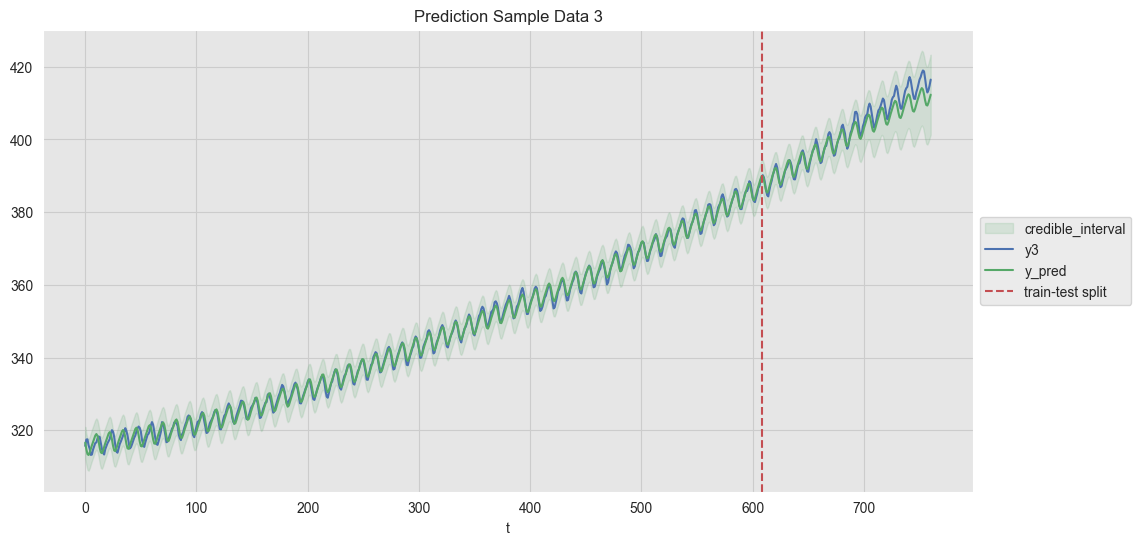

In [164]:
df['t'] = df.index

fig, ax = plt.subplots()

ax.fill_between(
    x=df['t'], 
    y1=df['y_pred_lwr'], 
    y2=df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='CO2', data=df, color=sns_c[0], label = 'y3', ax=ax)
sns.lineplot(x='t', y='y_pred', data=df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='');

## Model evaluation

In [165]:
print(f'R2 Score Train = {gp3.score(X=x_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp3.score(X=x_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3.predict(x_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp3.predict(x_test)): 0.3f}')

R2 Score Train =  0.998
R2 Score Test =  0.939
MAE Train =  0.757
MAE Test =  1.717


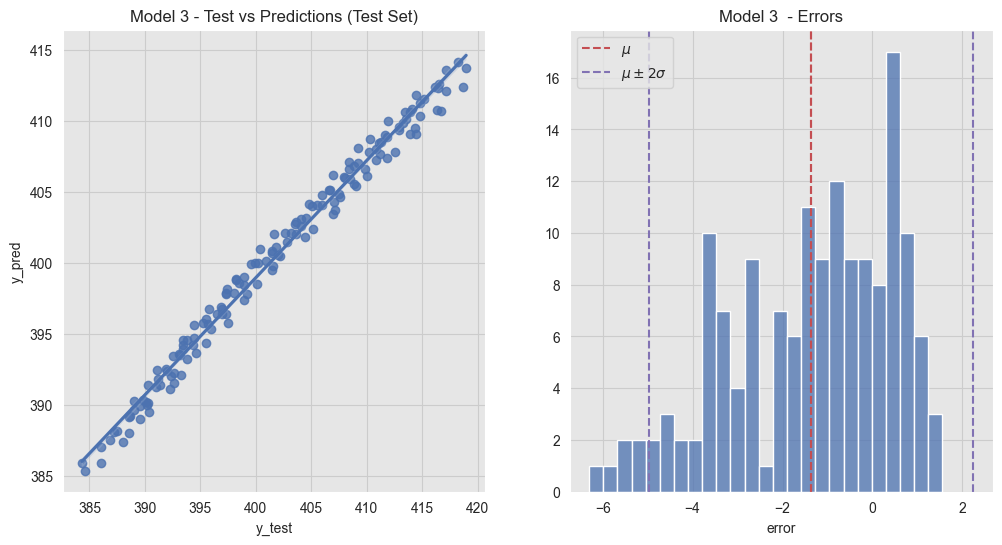

In [181]:
errors = gp3.predict(x_test) - np.squeeze(y_test)
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp3.predict(x_test).flatten(), ax=ax[0])
sns.histplot(data=errors, ax=ax[1], bins=25)
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 3 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 3  - Errors', xlabel='error', ylabel=None);